In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/NLP Project/data/adr_classification_dataset.csv'
df = pd.read_csv(file_path)

# Show the first few rows
df.head()

,text,label
0,Intravenous azithromycin-induced ototoxicity.,1
1,"Immobilization, while Paget's bone disease was...",1
2,Unaccountable severe hypercalcemia in a patien...,1
3,METHODS: We report two cases of pseudoporphyri...,1
4,METHODS: We report two cases of pseudoporphyri...,1


In [ ]:
# Print dataset shape
print(f"Shape of dataset: {df.shape}\n")

# Create summary table
summary = pd.DataFrame({
    'Column': df.columns,
    'Missing Values': df.isnull().sum().values,
    'Data Type': df.dtypes.values
})

# Display table
summary

Shape of dataset: (23516, 2)



,Column,Missing Values,Data Type
0,text,0,object
1,label,0,int64


In [ ]:
# Display how text column looks
df['text'].value_counts()

,count
text,
"A 27-year-old man who had a history of bronchial asthma, eosinophilic enteritis, and eosinophilic pneumonia presented with fever, skin eruptions, cervical lymphadenopathy, hepatosplenomegaly, atypical lymphocytosis, and eosinophilia two weeks after receiving trimethoprim (TMP)-sulfamethoxazole (SMX) treatment.",24
"CASE SUMMARY: A 65-year-old patient chronically treated with the selective serotonin reuptake inhibitor (SSRI) citalopram developed confusion, agitation, tachycardia, tremors, myoclonic jerks and unsteady gait, consistent with serotonin syndrome, following initiation of fentanyl, and all symptoms and signs resolved following discontinuation of fentanyl.",21
A case report.,21
"CONCLUSION: The new quinolone derivatives (levofloxacin, sparfloxacin, grepafloxacin, trovafloxacin, gatifloxacin and moxifloxacin), also called gyrase inhibitors, are known for their potential to cause central nervous system-related adverse effects, including headache, dizziness and insomnia.",18
"Three patients, in whom tumour overkill by cytotoxic treatment, including high dose methotrexate with folinic acid rescue, resulted in the 'phosphate shower syndrome' (hyper-uricaemia, hyperkalaemia and hyperphosphataemia with hypocalcaemia and tetany, with metabolic acidosis and acute renal impairment) are described.",16
...,...
Hemoglobin levels normalized after administration of enalapril was stopped.,1
"Magnetic resonance imaging showed several areas of abnormally high signal on T2-weighted images in the brainstem, thalamus, and mamillary bodies.",1
Both patients presented as self-referrals to the emergency department.,1


We can already see duplicates here.

In [ ]:
# Check number of duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 2620


In [ ]:
# Drop duplicate rows and reset index
df = df.drop_duplicates().reset_index(drop=True)

# Check shape after removal
print(f"New shape after dropping duplicates: {df.shape}")

New shape after dropping duplicates: (20896, 2)


In [ ]:
print("Unique labels:", df['label'].unique())
print("Number of unique texts:", df['text'].nunique())

Unique labels: [1 0]
Number of unique texts: 20896


In [ ]:
# # Filter rows where text contains "interventional case report"
# interventional_sentences = df[df['text'].str.contains('interventional case report', case=False, na=False)]

# # Get unique sentences as a set
# unique_interventional_sentences = set(interventional_sentences['text'])

# # Display the sentences
# for sentence in unique_interventional_sentences:
#     print(sentence)

### Label Distribution:

In [ ]:
# Get counts as a dictionary
counts = df['label'].value_counts().to_dict()

# Create DataFrame from counts
label_counts_df = pd.DataFrame(list(counts.items()), columns=['label', 'count'])

# Calculate percentages
label_counts_df['percentage'] = round((label_counts_df['count'] / label_counts_df['count'].sum()) * 100, 2)

# Display DataFrame
print("\nLabel Distribution:\n")
label_counts_df


Label Distribution:



,label,count,percentage
0,0,16625,79.56
1,1,4271,20.44


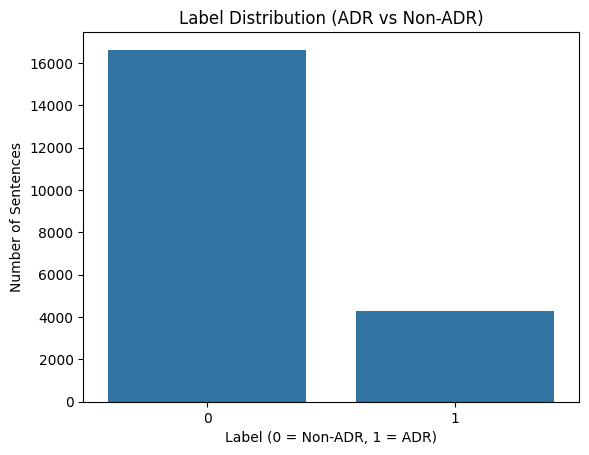

In [ ]:
# Plot label distribution
sns.countplot(x='label', data=df)
plt.title('Label Distribution (ADR vs Non-ADR)')
plt.xlabel('Label (0 = Non-ADR, 1 = ADR)')
plt.ylabel('Number of Sentences')
plt.show()

The dataset shows a clear class imbalance, with ~80% non-ADR sentences and ~20% ADR sentences. This imbalance should be considered during model training and evaluation.

In [ ]:
# Calculate sentence lengths
sentence_lengths = df['text'].apply(lambda x: len(str(x).split()))

# Get sentence length stats as DataFrame
sentence_stats = sentence_lengths.describe().round(2).to_frame().T

# Display
sentence_stats

,count,mean,std,min,25%,50%,75%,max
text,20896.0,17.81,8.61,1.0,12.0,17.0,23.0,135.0


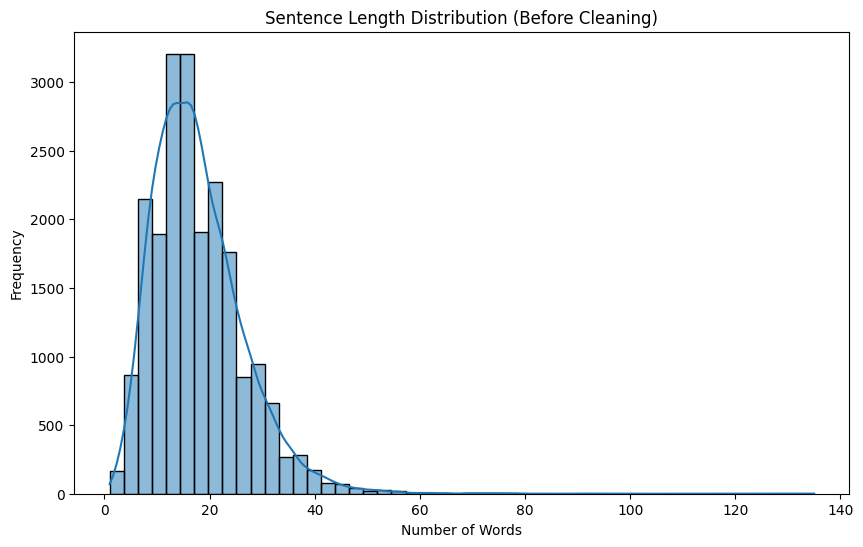

In [ ]:
# Display in plot
plt.figure(figsize=(10,6))
sns.histplot(sentence_lengths, bins=50, kde=True)
plt.title('Sentence Length Distribution (Before Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

We analyzed the distribution of sentence lengths in the ADE dataset (measured in word count per sentence). The dataset contains 20,896 sentences (after duplicates removal), with an average length of approximately 17.81 words (SD = 8.61). The shortest sentence contains 1 word, while the longest reaches 135 words. The 25th percentile is at 12 words, the median at 17 words, and the 75th percentile at 23 words. These results show that while most sentences are relatively short, the dataset includes some very long and complex sentences, which could impact both embedding-based models and LLM prompting (due to token limits and truncation risk).

### Checking Which Label Has Longer Sentences:

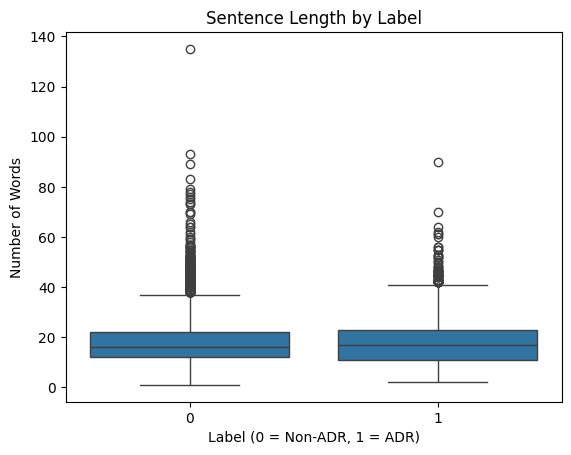

In [ ]:
sns.boxplot(x='label', y=sentence_lengths, data=df)
plt.title('Sentence Length by Label')
plt.xlabel('Label (0 = Non-ADR, 1 = ADR)')
plt.ylabel('Number of Words')
plt.show()

We visualized the sentence length distribution by label (ADR vs Non-ADR) before text cleaning. The plot shows that both classes have a similar spread and median number of words, but there are noticeable outliers with very long sentences, especially in the Non-ADR group. This suggests that cleaning and preprocessing will help reduce noise and potentially improve model performance by handling extreme-length cases.

In [ ]:
# Flatten all raw text into one big string - split into raw tokens
all_raw_words = [word.lower()
                 for sentence in df['text']
                 for word in str(sentence).split()]

# Count word frequencies
raw_word_freq = Counter(all_raw_words)

# Get top 20 most common words
most_common_raw = raw_word_freq.most_common(20)

print("\nTop 20 most common words:\n")
for word, count in most_common_raw:
    print(f"{word}, ({count})")

# Get top 20 least common words
least_common_raw = raw_word_freq.most_common()[:-21:-1]

print("\nTop 20 least common words:\n")
for word, count in least_common_raw:
    print(f"{word}, ({count})")


Top 20 most common words:

of, (17195)
the, (15709)
and, (11269)
a, (9481)
in, (8850)
with, (8247)
to, (6402)
was, (3976)
is, (3370)
for, (3313)
after, (2625)
patients, (2523)
patient, (2292)
this, (2136)
case, (2067)
treatment, (2047)
an, (1997)
by, (1920)
be, (1903)
that, (1773)

Top 20 least common words:

partial,, (1)
expressionless, (1)
scarred;, (1)
shrunken,, (1)
1132000/microl, (1)
410000/microl, (1)
world., (1)
duties, (1)
aviation, (1)
disqualification, (1)
overview:, (1)
ph., (1)
non-anion-gap, (1)
ounces, (1)
redox, (1)
beta-hydroxybutyrate, (1)
acetoacetate, (1)
(akbr),, (1)
ketone, (1)
hiv-seropositive, (1)


The most common words are generic stopwords like “of”, “the”, and “and” , while the least common words (appearing once) are rare medical terms (e.g., “hiv-seropositive”) and noisy tokens (e.g., “partial,,” and “overview;”).

### Text Cleaning:

In [ ]:
# Minimal cleaning function - lowercase + remove punctuation
def minimal_clean(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Apply cleaning
df['text'] = df['text'].apply(minimal_clean)

In [ ]:
df['text'].value_counts()

,count
text,
design interventional case report,2
development of platinum hypersensitivity can limit therapeutic options,1
it is therefore one of the most serious longterm complications of current cancer treatment and is likely to increase as longer survival rates for the primary tumour are achieved,1
rhodococcus equi is a bacterial pathogen of domestic animals that can infect immunocompromised patients especially those with impaired cellular immunity such as transplant recipients,1
although urinary incontinence is listed as one side effect of these drugs in their package inserts there is only one report in the literature,1
...,...
syndrome malinlike symptoms probably due to interaction between neuroleptica and oral antidiabetic agents,1
this process was not reversed by lamivudine therapy hemodialysis and the use of a molecular adsorbent recirculating system,1
it is particularly important in the treatment of systemic lupus erythematosus sle since it reduces new organ involvement and disease flares and relieves skin and joint symptoms,1


In [ ]:
# Find duplicated texts (keep both rows)
duplicates_df = df[df['text'].duplicated(keep=False)]

# Show them
duplicates_df

,text,label
8098,design interventional case report,0
13664,design interventional case report,0


In [ ]:
df = df.drop_duplicates(subset='text', keep='first').reset_index(drop=True)

One of them was Interventional, and after cleaning, it turned into interventional. We will remove it since it means the same thing and has the same label.

In [ ]:
df.shape

(20895, 2)

### Word Statistics:

In [ ]:
# Flatten all tokens into one big list
all_words = [word for sentence in df['text'] for word in sentence.split()]

# Count total words
total_word_count = len(all_words)
print(f"Total number of words: {total_word_count}")

# Count unique words
unique_word_count = len(set(all_words))
print(f"\nNumber of unique words: {unique_word_count}")

# Get word frequencies
word_freq = Counter(all_words)

# Get top 20 most common words
most_common_words = word_freq.most_common(20)

# Print top 20 most common words as grocery list
print("\nTop 20 most common words:\n")
for word, count in most_common_words:
    print(f"{word},({count})")

# Get top 20 least common words (appear only once or few times)
least_common_words = word_freq.most_common()[:-21:-1]

# Print top 20 least common words as grocery list
print("\nTop 20 least common words:\n")
for word, count in least_common_words:
    print(f"{word},({count})")

Total number of words: 371956

Number of unique words: 20119

Top 20 most common words:

of,(17205)
the,(15722)
and,(11320)
a,(9510)
in,(8858)
with,(8260)
to,(6408)
was,(3977)
is,(3383)
for,(3316)
patients,(3215)
after,(2627)
patient,(2543)
treatment,(2510)
case,(2215)
this,(2144)
therapy,(2063)
an,(1999)
by,(1922)
be,(1904)

Top 20 least common words:

expressionless,(1)
scarred,(1)
shrunken,(1)
1132000microl,(1)
410000microl,(1)
duties,(1)
aviation,(1)
disqualification,(1)
nonaniongap,(1)
ounces,(1)
redox,(1)
betahydroxybutyrate,(1)
acetoacetate,(1)
ketone,(1)
hivseropositive,(1)
socioeconomic,(1)
minisatellite,(1)
ychromosome,(1)
igg1kappa,(1)
regressing,(1)


### Words per Sentence:

In [ ]:
# Calculate sentence lengths
sentence_lengths_cleaned = df['text'].apply(lambda x: len(x.split()))

# Get word statistics per sentence
sentence_stats_cleaned_summary = sentence_lengths_cleaned.describe().round(2).to_frame().T

# Display
print("Word Statistics per Sentence:\n")
sentence_stats_cleaned_summary

Word Statistics per Sentence:



,count,mean,std,min,25%,50%,75%,max
text,20895.0,17.8,8.6,1.0,12.0,17.0,22.0,122.0


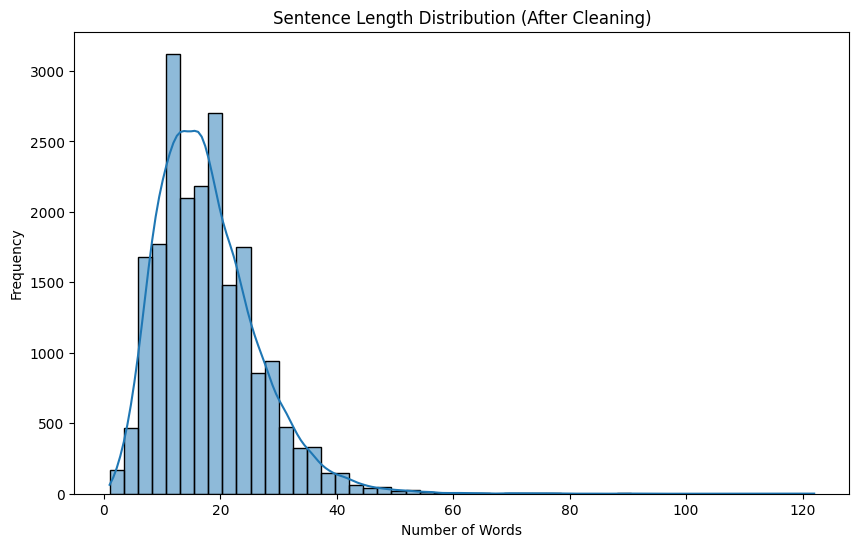

In [ ]:
# Display in plot
plt.figure(figsize=(10,6))
sns.histplot(sentence_lengths_cleaned, bins=50, kde=True)
plt.title('Sentence Length Distribution (After Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

There is a sentence with 122 words and with 1. Thus, we will check the longest and shortest sentences and their labels.

In [ ]:
# Calculate sentence lengths as a variable
sentence_lengths = df['text'].apply(lambda x: len(x.split()))

# Find the shortest sentence
shortest_idx = sentence_lengths.idxmin()
shortest_sentence = df.loc[shortest_idx, 'text']
shortest_length = sentence_lengths[shortest_idx]
shortest_label = df.loc[shortest_idx, 'label']

# Find the longest sentence
longest_idx = sentence_lengths.idxmax()
longest_sentence = df.loc[longest_idx, 'text']
longest_length = sentence_lengths[longest_idx]
longest_label = df.loc[longest_idx, 'label']

# Display results
print(f"Shortest sentence:\n\n({shortest_length} words, label {shortest_label}):\n{shortest_sentence}\n")
print(f"Longest sentence:\n\n({longest_length} words, label {longest_label}):\n{longest_sentence}\n")

Shortest sentence:

(1 words, label 0):
abemayor

Longest sentence:

(122 words, label 0):
serum aluminum levels were significantly p less than 0001 higher in these 3 infants and in 1 other all of whom received more than 100 mg of elemental aluminum per kilogram of body weight per day mean  sd 3710  1789 ng per milliliter 1375  66 mumol per liter  than they were in 8 older children with azotemia who were not undergoing dialysis and who received less than 100 mg of elemental aluminum per kilogram per day 270  186 ng per milliliter 10  068 mumol per liter  7 such children who did not receive aluminum hydroxide 2028  92 ng per milliliter 075  034 mumol per liter  and 16 children with normal renal function 2104  49 ng per milliliter 078  018 mumol per liter 



### Checking Which Label Has Longer Sentences:

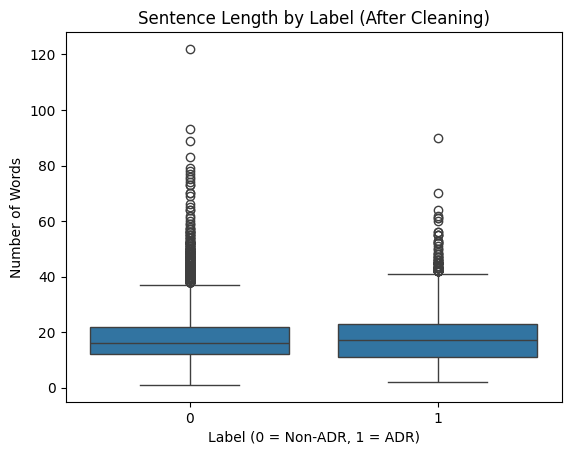

In [ ]:
# Plot sentence length distribution by label
sns.boxplot(x=df['label'], y=sentence_lengths_cleaned)
plt.title('Sentence Length by Label (After Cleaning)')
plt.xlabel('Label (0 = Non-ADR, 1 = ADR)')
plt.ylabel('Number of Words')
plt.show()

After subtle cleaning, the average sentence length is ~17.8 words with a max of 122, and both ADR and Non-ADR groups show similar distributions. The Non-ADR group still has more extreme outliers, reflecting some very long sentences.

In [ ]:
# Get counts as a dictionary
counts = df['label'].value_counts().to_dict()

# Create DataFrame from counts
label_counts_df = pd.DataFrame(list(counts.items()), columns=['label', 'count'])

# Calculate percentages
label_counts_df['percentage'] = round((label_counts_df['count'] / label_counts_df['count'].sum()) * 100, 2)

# Display DataFrame
print("\nLabel Distribution:\n")
label_counts_df


Label Distribution:



,label,count,percentage
0,0,16624,79.56
1,1,4271,20.44


### Letters per Word:

In [ ]:
# Calculate total words and total letters
total_words = len(all_words)
total_letters = sum(len(word) for word in all_words)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Total Words', 'Total Letters'],
    'Value': [total_words, total_letters]
})

# Display summary DataFrame
summary_df

,Metric,Value
0,Total Words,371956
1,Total Letters,2234037


In [ ]:
# Calculate letter statistics per word (only count shows word amount)

word_lengths = [len(word) for word in all_words]

# Convert to a pandas Series for easy summary stats
word_lengths_series = pd.Series(word_lengths, name='Amount')

# Print summary statistics
print("Letter Statistics per Word:\n")
word_lengths_series.describe().round(2)

Letter Statistics per Word:



,Amount
count,371956.00
mean,6.01
std,3.60
min,1.00
25%,3.00
50%,5.00
75%,8.00
max,42.00


In [ ]:
# Count number of words per character length
length_counts = word_lengths_series.value_counts().sort_index()

# Display as a DataFrame
length_counts_df = pd.DataFrame({
    'word_length': length_counts.index,
    'count': length_counts.values
})

length_counts_df

,word_length,count
0,1,12719
1,2,54581
2,3,54419
3,4,40355
4,5,29796
5,6,23527
6,7,30726
7,8,33219
8,9,29364
9,10,20875


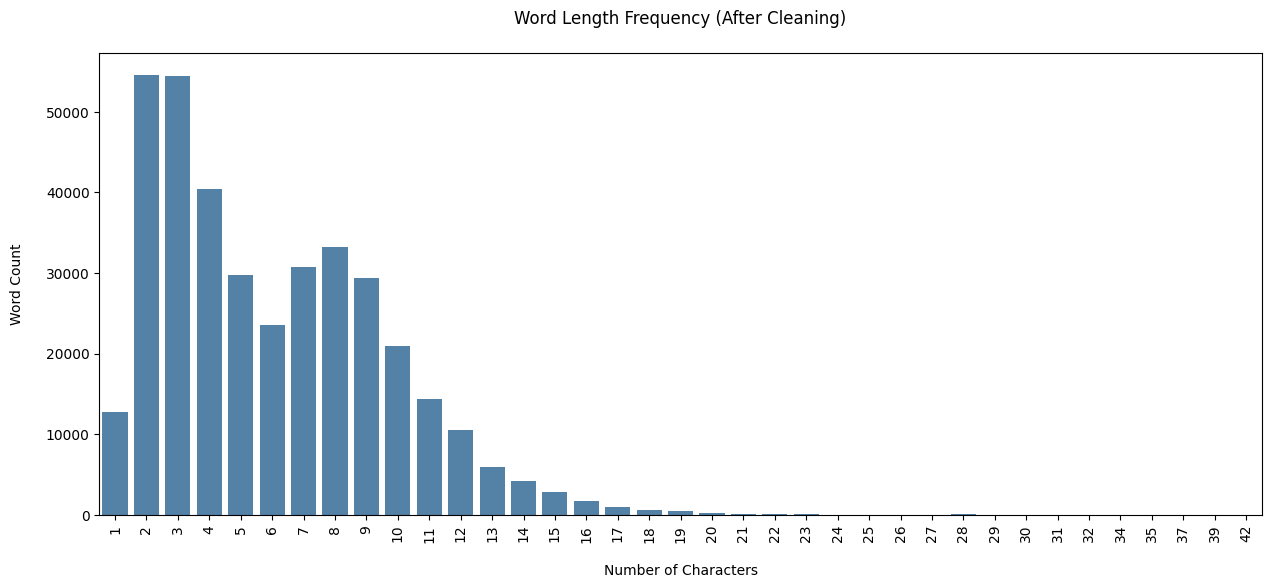

In [ ]:
# Plotting the results
plt.figure(figsize=(15, 6))
sns.barplot(x=length_counts.index, y=length_counts.values, color='steelblue')
plt.title('Word Length Frequency (After Cleaning)\n')
plt.xlabel('\nNumber of Characters')
plt.ylabel('Word Count\n')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Find all words with length >= 30
long_words = [word for word in all_words if len(word) >= 30]

# Get unique long words
unique_long_words = set(long_words)

# Display the unique long words
print("Words with 30 and more letters:\n")
for word in unique_long_words:
    print(word)

Words with 30 and more letters:

trimethoprimsulfamethoxazoleinduced
reuptakeinhibitorsmetoclopramide
microbiologicalcharacteristics
histologicalimmunohistochemical
34methylenedioxymetamphetamine
hypothalamicpituitaryadrenocortical
s23aminopropylaminoethylphosphorothioic
glipizidetrimethoprimsulfamethoxazole
clinicalelectroencephalographic
antineoplasticimmunosuppressive
34methylenedioxymethamphetamine
n4behenoyl1betadarabinofuranosyl
chromatographynitrogenphosphorus
1betadarabinofuranosylcytosine
methicillinresistantstaphylococcus
2chlorophenyl4chlorophenyl11dichloroethane
polyendocrinopathycandidiasisectodermal
multipleantimicrobialresistant
tricyclicantidepressantinduced
prothipendylhydrochlorideinduced
8hydroacydesmethylclomipramine


We identified several unusually long words (≥30 characters), which are often complex medical terms, chemical names, or drug identifiers.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20895 entries, 0 to 20894
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20895 non-null  object
 1   label   20895 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 326.6+ KB


### Baseline Model:

Since our dataset is imbalanced, with approximately 80% Non-ADR and 20% ADR examples, we will apply downsampling to the Non-ADR class to match the number of ADR examples. This ensures a balanced dataset, helping to prevent the model from being biased toward the majority class. By doing so, we aim to improve the model’s ability to correctly identify ADR cases and achieve more reliable performance metrics during evaluation.

In [ ]:
# Separate majority and minority classes
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

# Downsample majority class
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=0)

# Combine minority class with downsampled majority class
df = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the balanced dataset
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Check the new label distribution
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']
label_counts

,Label,Count
0,0,4271
1,1,4271


In [ ]:
# Split data into train+dev and test first (80% train+dev, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=0
)

# Split train+dev into train and dev (75% train, 25% dev → overall 60% train, 20% dev, 20% test)
X_train, X_dev, y_train, y_dev = train_test_split(
    X_temp, y_temp,
    test_size=0.25, stratify=y_temp, random_state=0
)

# Vectorize with Bag of Words (fit only on training set)
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_dev_vec = vectorizer.transform(X_dev)
X_test_vec = vectorizer.transform(X_test)

# Train Naive Bayes on training set
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Predict on train set
y_train_pred = nb_model.predict(X_train_vec)

# Calculate train metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Predict on dev set
y_dev_pred = nb_model.predict(X_dev_vec)

# Calculate dev metrics
dev_accuracy = accuracy_score(y_dev, y_dev_pred)
dev_precision = precision_score(y_dev, y_dev_pred)
dev_recall = recall_score(y_dev, y_dev_pred)
dev_f1 = f1_score(y_dev, y_dev_pred)

# Predict on test set
y_test_pred = nb_model.predict(X_test_vec)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Create DataFrame with results
metric_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train Score': [round(train_accuracy, 2), round(train_precision, 2), round(train_recall, 2), round(train_f1, 2)],
    'Dev Score': [round(dev_accuracy, 2), round(dev_precision, 2), round(dev_recall, 2), round(dev_f1, 2)],
    'Test Score': [round(test_accuracy, 2), round(test_precision, 2), round(test_recall, 2), round(test_f1, 2)]
})

# Display DataFrame
metric_table

,Metric,Train Score,Dev Score,Test Score
0,Accuracy,0.91,0.77,0.77
1,Precision,0.87,0.73,0.73
2,Recall,0.96,0.85,0.84
3,F1 Score,0.91,0.79,0.78


The baseline model, using a Naive Bayes classifier with a Bag-of-Words representation, achieves 0.77 accuracy, 0.73 precision, 0.85 recall, and 0.79 F1 on the dev set, and 0.77, 0.73, 0.84, and 0.78 on the test set, respectively. The results show strong ability to capture ADR cases (high recall) and consistent performance across dev and test, even without advanced tuning or balancing.